In [1]:
# 自作モジュールの参照先を上書き
import sys
parent_dir = 'Predict-Future-Sales'
p_sub = sys.path[0]

ride = ''
for path in p_sub.split('/'):
    if path != parent_dir:
        ride = ride + path + '/'
    else:
        ride = ride + path + '/'
        break
sys.path[0] = ride


import time
import pickle

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
import torch.nn as nn
from torch.optim import Adam

from module.lino_module.preprocess import mode_of_freq, tde_dataset_wm, select_device
from module.lino_module.model import TransformerModel
from module.lino_module.training import training
from module.lino_module.ploter import learning_plot, confirmation, to_time_series,\
                                        confirmation_plot

# 乱数固定
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

/Users/lino/opt/anaconda3/envs/for_pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## データセットの準備

In [2]:
data = pd.read_csv('../data/sales_train.csv')
data = mode_of_freq(data).item_cnt_day
seq = 14
d_model = 16
dilation = 3
src_tgt_seq = (int(seq * 0.7),int(seq * 0.7))
step_num = seq - int(seq * 0.7)
scaler = StandardScaler

kwrgs = {'data': data,
         'seq': seq,
         'd_model': d_model,
         'dilation': dilation,
         'src_tgt_seq': src_tgt_seq,
         'step_num': step_num,
         'daily': True,
         'weekly': True,
         'weekly_num': True,
         'monthly': True,
         'scaler': scaler,
         'batch_size': 64,
         'train_rate': 0.9}

train, test = tde_dataset_wm(**kwrgs)
print(f'seq: {seq}, src_tgt_seq: {src_tgt_seq}, step_num: {step_num}')

seq: 14, src_tgt_seq: (9, 9), step_num: 1


## Transformerモデルの準備

In [3]:
# device = select_device() # mps では Transformer の attention でエラー
device = torch.device('cpu')

cat_dim = kwrgs['daily'] + kwrgs['weekly'] + kwrgs['weekly_num'] + kwrgs['monthly']
dim = d_model * (cat_dim + 1)

# モデルと損失関数
transformer = TransformerModel(d_model=dim, nhead=8, device=device).to(device)
# criterion = RMSELoss()  # 論文ではRMSELoss
criterion = nn.MSELoss().to(device)

# 学習率その他は論文の値を参考
warmup_steps = 5000
lr = d_model**0.5 * min(step_num**0.5, step_num * warmup_steps**(-1.5))
optimizer = Adam(transformer.parameters(), lr=lr, betas=(0.95, 0.98), eps=10e-9)

## 訓練

In [4]:
epochs = 100
training_kwrgs = {'model': transformer,
                  'train': train,
                  'test': test,
                  'device': device,
                  'criterion': criterion,
                  'optimizer': optimizer,
                  'epochs': epochs,
                  'verbose': 10,
                  'center': 50}
transformer, loss_pack = training(**training_kwrgs)
train_loss, validation_loss, test_loss = loss_pack

--------------------- start ----------------------
                     epoch_0                      
train_loss:  1.5622 | validation_loss:  1.6176 | test_loss:  1.3892
                     epoch_10                     
train_loss:  0.6632 | validation_loss:  0.5811 | test_loss:  0.2496
                     epoch_20                     
train_loss:  0.4429 | validation_loss:  0.3671 | test_loss:  0.2529
                     epoch_30                     
train_loss:  0.3584 | validation_loss:  0.2829 | test_loss:  0.1797
                     epoch_40                     
train_loss:  0.3104 | validation_loss:  0.2445 | test_loss:  0.1607
                     epoch_50                     
train_loss:  0.2825 | validation_loss:  0.2193 | test_loss:  0.1433
                     epoch_60                     
train_loss:  0.2634 | validation_loss:  0.1993 | test_loss:  0.1416
                     epoch_70                     
train_loss:  0.2416 | validation_loss:  0.1821 | test_loss:  0.11

## 訓練データ損失と検証データ損失

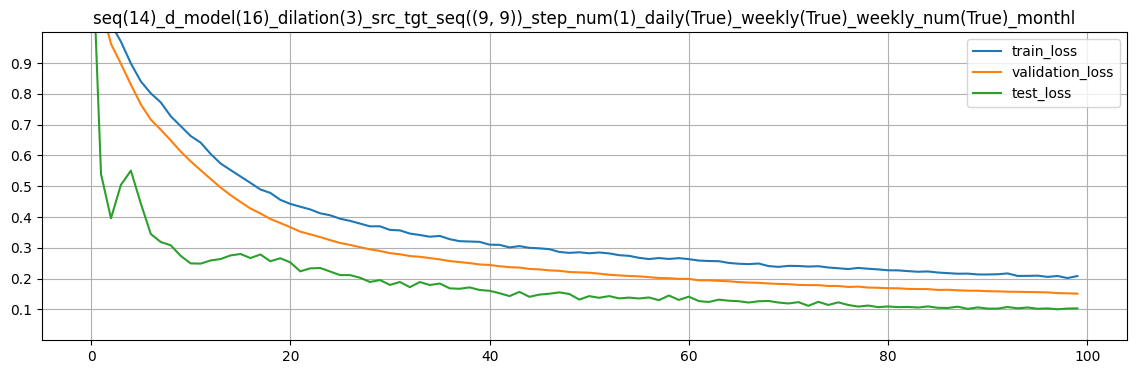

In [5]:
# ファイル名の作成
name = ''
del kwrgs['batch_size'], kwrgs['train_rate']
for key, value in kwrgs.items():
    if key=='data':
        pass
    elif key=='scaler':
        name += f'{key}({value.__name__})_'
    else:
        name += f'{key}({value})_'

img_path = './imgs/img_wm/'
figsize = (14, 4)
saving = True
learning_plot(train_loss, validation_loss, test_loss,  img_path, name, scaler, figsize, saving)

## 訓練データとテストデータで予測

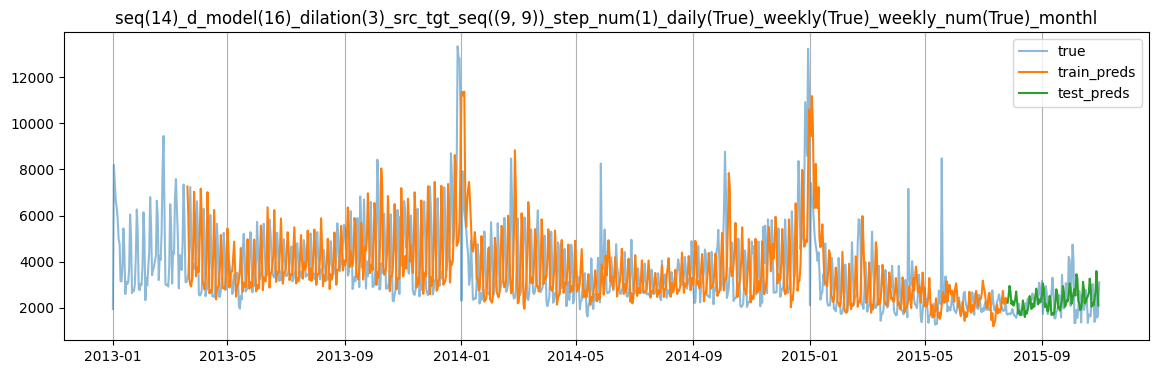

In [6]:
figsize = (14, 4)
train_preds, test_preds = confirmation(transformer, train, test, device)
train_time_series, test_time_series, original = to_time_series(data, train_preds, test_preds, scaler, d_model, dilation, seq)
confirmation_plot(train_time_series, test_time_series, original, img_path, name, figsize, saving)

## モデルの保存

In [7]:
kwrgs['model'] = transformer
model_dir = './models/models_wm/'
model_name = f'epochs({epochs})' + name + '.pkl'
with open(model_dir + model_name, 'wb') as f:
    pickle.dump(kwrgs, f)

>

### 以下は訓練のために作成したクラスおよび関数

In [8]:
import math

import torch
import torch.nn as nn

from torch import Tensor


class TransformerModel(nn.Module):
    """Trasnsormer for Time Series
        参考論文: https://arxiv.org/abs/2001.08317
    """
    def __init__(self, d_model: int, nhead: int, device):
        super(TransformerModel, self).__init__()

        self.positional = PositionalEncoding(d_model)
        self.device = device

        encoder_layer = nn.TransformerEncoderLayer(
                                                d_model,
                                                nhead,
                                                dropout=0.2,
                                                batch_first=True
                                                )
        self.transformer_encoder = nn.TransformerEncoder(
                                                    encoder_layer,
                                                    num_layers=4
                                                    )

        decoder_layer = nn.TransformerDecoderLayer(
                                                d_model,
                                                nhead,
                                                dropout=0.2,
                                                batch_first=True
                                                )
        self.transformer_decoder = nn.TransformerDecoder(
                                                decoder_layer,
                                                num_layers=4
                                                )
        self.linear = nn.Linear(d_model, 1)

    def forward(self, src: Tensor, tgt: Tensor) -> Tensor:
        # Decoder用のtgt_maskを作成
        _, tgt_seq, _ = tgt.shape
        tgt_mask = _generate_mask(tgt_seq)   # A-look ahead mask

        # Positional Encoding
        src = self.positional(src)
        # Encoder
        memory = self.transformer_encoder(src)
        # Decoder
        output = self.transformer_decoder(tgt, memory, tgt_mask.to(self.device))
        # 線形変で出力の形状へ
        pred = self.linear(output)
        return pred


def _generate_mask(tgt_seq: int) -> Tensor:
    """デコーダ入力用の Self Attention用のマスクを作成"""
    inf_mask = torch.ones(tgt_seq, tgt_seq) * float('-inf')
    tgt_mask = torch.triu(inf_mask, diagonal=1)
    return tgt_mask


class PositionalEncoding(nn.Module):
    """PositionalEnoder"""
    def __init__(self, d_model: int, max_len=5000):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x: Tensor) -> Tensor:
        x = x + self.pe[: x.size(0), :]
        return x


class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y, t):
        return torch.sqrt(self.mse(y, t))

In [9]:
import time

import torch
from torch import Tensor
from torch.utils.data import DataLoader

from typing import Tuple


def training(model: object,
             train: DataLoader,
             test: DataLoader,
             device: torch.device,
             criterion: object,
             optimizer: object,
             epochs: int,
             verbose=10,
             center=80) -> Tuple[object, Tensor, Tensor]:
    """訓練用関数"""
    train_loss = []
    validation_loss = []
    test_loss = []
    print(' start '.center(center, '-'))
    start_point = time.time()
    for epoch in range(epochs):
        train_epoch_loss = []
        validation_epoch_loss = []

        cache = None
        for i, pack in enumerate(train):
            src, tgt, y = [content.to(device) for content in pack]
            # モデル訓練
            if i == 0:
                pass
            else:
                # キャッシュから１バッチ前のデータで訓練
                cached_src, cached_tgt, cached_y = cache
                model.train()
                optimizer.zero_grad()
                output = model(cached_src, cached_tgt)
                loss = criterion(output.squeeze(), cached_y)
                train_epoch_loss.append(loss.item())
                # 勾配計算
                loss.backward()
                optimizer.step()
            # モデル評価
            model.eval()
            output = model(src, tgt)
            loss = criterion(output.squeeze(), y)
            validation_epoch_loss.append(loss.item())
            # データをキャッシュに保存して次回の訓練データにする
            cache = (src, tgt, y)

        test_epoch_loss = []
        for pack in test:
            src, tgt, y = [content.to(device) for content in pack]
            model.eval()
            output = model(src, tgt)
            loss = criterion(output.reshape(-1), y.reshape(-1))
            test_epoch_loss.append(loss.item())

        validation_loss.append(validation_epoch_loss)
        train_loss.append(train_epoch_loss)
        test_loss.append(test_epoch_loss)

        if epoch % verbose == 0:
            print(f' epoch_{epoch} '.center(center))
            train_mean = torch.mean(torch.tensor(train_epoch_loss)).item()
            valid_mean = torch.mean(torch.tensor(validation_epoch_loss)).item()
            test_mean = torch.mean(torch.tensor(test_epoch_loss)).item()
            print('train_loss: ', round(train_mean, 4),
                  '| validation_loss: ', round(valid_mean, 4),
                  '| test_loss: ', round(test_mean, 4))

    print(' complete!! '.center(center, '-'))
    print(f'Execution_time: {round(time.time() - start_point, 3)}')
    packs = (train_loss, validation_loss, test_loss)
    loss_pack = [torch.tensor(loss) for loss in packs]
    return model, loss_pack
